In [2]:
import torch
import networkx as nx
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from sklearn.metrics import r2_score 
import time 
from matplotlib import pyplot as plt 
import copy

import sys 
sys.path.append('../src/')

from src.models.GSNN import GSNN
from src.data.LincsDataset import LincsDataset
from src.models import utils 

%load_ext autoreload
%autoreload 2

In [3]:
if torch.cuda.is_available() & True:
    device = 'cuda'
else: 
    device = 'cpu'

print('using device', device)

using device cuda


In [4]:
data = torch.load('./processed_data/Data.pt')

In [5]:
data = torch.load('./processed_data/Data.pt')

train_ids = np.load('./processed_data/train_obs.npy', allow_pickle=True)
train_dataset = LincsDataset(root='./processed_data/', sig_ids=train_ids)
train_loader = DataLoader(train_dataset, batch_size=10, num_workers=12, shuffle=True)

test_ids = np.load('./processed_data/test_obs.npy', allow_pickle=True)
test_dataset = LincsDataset(root='./processed_data/', sig_ids=test_ids)
test_loader = DataLoader(test_dataset, batch_size=100, num_workers=4, shuffle=True)

In [6]:
model2 = torch.load('./output/223129e4-6ed2-4a63-928e-5ff2387525c8/model.pt')

In [5]:
# redo 
# for input edge mask
#   permute dst - use choice(func nodes)

# for not input edge or output edge 
#   permute src, dst - use choice (func nodes)

# for output edge mask 
#   permute src - uwse choice(func nodes)

if False: 
    print('NOTE: RANDOMIZING EDGE INDEX')
    # permute edge index 
    edge_index = copy.deepcopy(data.edge_index)
    func_nodes  = (~(data.input_node_mask | data.output_node_mask)).nonzero(as_tuple=True)[0].detach().cpu().numpy()

    src,dst = edge_index[:, data.input_edge_mask]
    dst = torch.tensor(np.random.choice(func_nodes, size=(len(dst))), dtype=torch.long)
    edge_index[:, data.input_edge_mask] = torch.stack((src, dst), dim=0)


    func_edge_mask = ~(data.input_edge_mask | data.output_edge_mask)
    src,dst = edge_index[:, func_edge_mask]
    src = torch.tensor(np.random.choice(func_nodes, size=(len(dst))), dtype=torch.long)
    dst = torch.tensor(np.random.choice(func_nodes, size=(len(dst))), dtype=torch.long)
    edge_index[:, func_edge_mask] = torch.stack((src, dst), dim=0)


    src,dst = edge_index[:, data.output_edge_mask]
    src = torch.tensor(np.random.choice(func_nodes, size=(len(dst))), dtype=torch.long)
    edge_index[:, data.output_edge_mask] = torch.stack((src, dst), dim=0)

else: 
    edge_index = data.edge_index

In [6]:
model = GSNN(edge_index=edge_index, 
             channels=5, 
             input_node_mask=data.input_node_mask, 
             output_node_mask=data.output_node_mask, 
             layers=10, 
             dropout=0.1,
             nonlin=torch.nn.ELU).to(device)

In [7]:
n_params = sum([p.numel() for p in model.parameters()])
print('# params', n_params)

# params 147622


In [8]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.MSELoss()

In [9]:
#model = torch.compile(model)

In [10]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [11]:
for epoch in range(50):
    big_tic = time.time()
    model = model.train()
    losses = []
    for i,(x, y, sig_id) in enumerate(train_loader): 
        tic = time.time()
        optim.zero_grad() 

        yhat = model(x.to(device))[:, data.output_node_mask]
        y = y.to(device).squeeze(-1)[:, data.output_node_mask]

        loss = crit(yhat, y)
        loss.backward()
        optim.step()

        with torch.no_grad(): 

            yhat = yhat.detach().cpu().numpy() 
            y = y.detach().cpu().numpy() 
            
            r2 = r2_score(y, yhat, multioutput='variance_weighted')
            r_flat = np.corrcoef(y.ravel(), yhat.ravel())[0,1]
            losses.append(loss.item())

            print(f'epoch: {epoch} || batch: {i}/{len(train_loader)} || loss: {loss.item():.3f} || r2: {r2:.3f} || r (flat): {r_flat:.2f} || elapsed: {(time.time() - tic):.2f} s' , end='\r')

    loss_train = np.mean(losses)

    y,yhat,sig_ids = utils.predict_gsnn(test_loader, model, data, device)
    r2_test = r2_score(y, yhat, multioutput='variance_weighted')
    r_flat_test = np.corrcoef(y.ravel(), yhat.ravel())[0,1]

    print(f'Epoch: {epoch} || loss (train): {loss_train:.3f} || r2 (test): {r2_test:.2f} || r flat (test): {r_flat_test:.2f} || elapsed: {(time.time() - big_tic)/60:.2f} min')

Epoch: 0 || loss (train): 4.619 || r2 (test): -0.05 || r flat (test): 0.29 || elapsed: 31.30 min


KeyboardInterrupt: 

In [1]:
model2 = torch.load('./output/223129e4-6ed2-4a63-928e-5ff2387525c8/model.pt')

NameError: name 'torch' is not defined

In [1]:
r2_score(y, yhat, multioutput='variance_weighted')

NameError: name 'r2_score' is not defined

In [14]:
np.corrcoef(y.ravel(), yhat.ravel())[0,1]

0.563240377957995

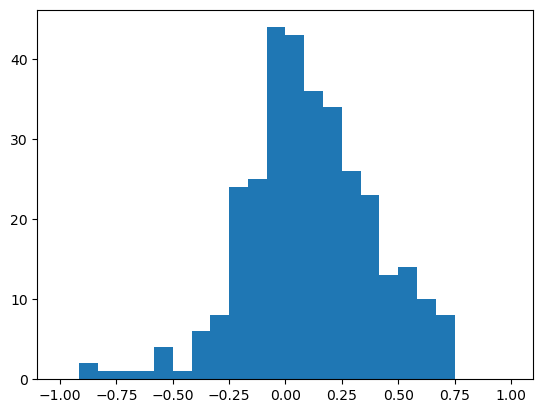

In [15]:
gene_r2 = r2_score(y, yhat, multioutput='raw_values')
np.save('./gsnn_test_gene_r2.npy', gene_r2)

plt.figure()
plt.hist(gene_r2, bins=np.linspace(-1,1,25))
plt.show()

In [16]:
nn_r2 = np.load('./nn_test_gene_r2.npy')
gsnn_r2 = np.load('./gsnn_test_gene_r2.npy')

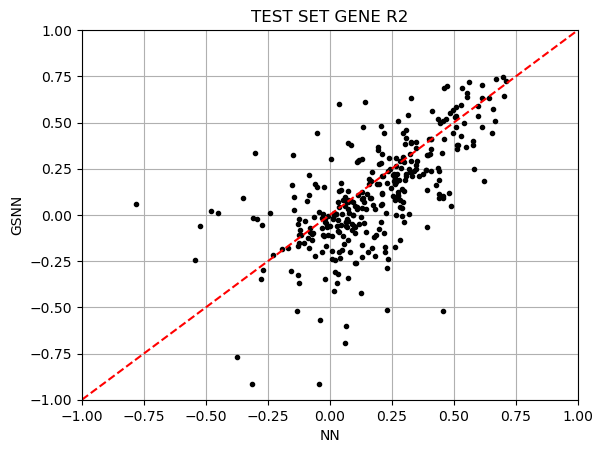

In [19]:
plt.figure()
plt.plot(nn_r2, gsnn_r2, 'k.')
plt.plot((-1,1), (-1,1), 'r--')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('NN')
plt.ylabel('GSNN')
plt.title('TEST SET GENE R2')
plt.grid()
plt.show()